# Using MonoTools fit

Here we will go through a few examples of how to fit a mono (one transit) or duo (two transit) transiting planet system using MonoTools.

This will cover:
* Accessing lightcurve & stellar parameter data
* Fitting duotransits and monotransits by marginalising over discrete parameter spaces in multiple parameters
* Fitting such systems using the in-built margnial velocity interpolator (fastest method)
* Fitting systems which also have RVs
* Plotting the outputs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

#The following may need to be MonoTools.MonoTools if you are importing from outside this folder:
from MonoTools import fit, tools, starpars

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


All data is stored in the following path which you can update in the commandline using $MONOTOOLSPATH

In [2]:
tools.MonoData_savepath

'/Volumes/LUVOIR/MonoToolsData'

### Loading Lightcurves & Stellar Params

Lightcurves are a dictionary with a few important arrays - `time`, `flux`, `flux_err` as well as:
* `cadence` - in the form "[mission letter][cadence in nearest minute]", e.g. T2 (for 2-minute TESS data), or K30 (for 30-min Kepler or K2 data). This should ideally be in an array form with matching length to `time`
* `mask` - in the form of a boolean, where those True points are the cadences to be used.
* `jd_base` - zero-point of time in BJD

However, you don't need to worry about this, because you can load lightcurves from all surveys using:

In [3]:
lc,hdr = tools.openLightCurve(270341214,'tess',sectors=np.arange(1,14))

And stellar params using a similar method. This will take the stellar info from the TICv8 catalogue:

In [4]:
info,_,_ = starpars.getStellarInfoFromCsv(270341214,'tess') #Ignore the second and third outputs here.

Breaking because status = COMPLETE


This candidate has both a monotransit and a duotransit, so is perfect for testing our code.

#### Priming the model:
Ok, first we need to initialise our model using the lightcurve and ID:

In [5]:
model = fit.monoModel(270341214, 'tess', lc=lc)

Next we need to add stellar parameters. These have the form `[value, neg_err, pos_err]`

In [6]:
# Adding stellar parameters:
model.init_starpars(Rstar=info[['rad','eneg_rad','epos_rad']].values,
                    rhostar=info[['rho','eneg_rho','epos_rho']].values,
                    Teff=info[['teff','eneg_teff','epos_teff']].values,
                    logg=info[['logg','eneg_logg','epos_logg']].values,
                    FeH=0.0)

Now we're ready to start adding planets to the model. We can either use `add_mono`, `add_duo` and `add_multi`, or we can use `model.add_planet()` with the planet type specified. Here we'll use the former:

In [7]:
model.add_duo({'tcen':1333.4075,'tcen_2':1660.72,'tdur':0.46,'depth':5.5e-3},'00') #We must include the new "name" for the planet, e.g. "00" or "b"

model.add_planet('mono',{'tcen':1682.12,'tdur':0.56,'depth':4.5e-3,'b':0.3},'01')

In [10]:
#These planets end up in the model.planets dictionary:
[{key:model.planets[p][key] for key in ['tcen','depth','period','b']} for p in model.planets]

[{'tcen': 1660.72, 'depth': 0.0055, 'period': 327.3125, 'b': 0.1},
 {'tcen': 1682.12, 'depth': 0.0045, 'period': 999, 'b': 0.3}]

# Initialising the model fit

Finally, now we have all candidates included, we can initialise the model! 

There are many keywords to use here, so here's a quick run-down of the important ones:
- `assume_circ` - bool - Assume circular orbits (no ecc & omega)? The default is `False`
- `use_GP` - bool - Use a GP for systemtatics+stellar variability?  The default is `True`
- `train_GP` - bool - Train the GP on out-of-transit data?  The default is `True`
- `constrain_LD` - bool - Constrain limb darkening params from model? The default is `True`
- `ld_mult` - float - How much to multiply theoretical LD param uncertainties to account for systematics. Default=3
- `useL2` - bool - Fit for "second light" (i.e. a binary or planet+blend) The default is `False`
- `LoadFromFile` - bool - Load previous model? The default is `False` (i.e. starts a new fit each time)
- `cutDistance` - float - cut out points further than `cutDistance*Tdur`. 0.0 means no cutting. Default=3.75
- `maskdist` - float - Distance, in transit durations, from transits, to "mask" when e.g. flattening. Default=0.666
- `pred_all_time` - bool - use the GP to predict all times, or only near transits? The default is `False` as this is usually too computationally intensive
- `fit_params` - list of strings of parameters to be fitted _globally_. Options: `['logror', 'b' or 'tdur', 'ecc', 'omega']`. The default is `['logror','b','tdur', 't0']`
- `marginal_params` - llist of strings of parameters to be fitted _marginally_ - i.e. for each period alias and/or gap. Options: `['per', 'b' or 'tdur', 'ecc', 'omega','logror']`, Default: `['per','ecc','omega']`
- `interpolate_v_prior` - bool - Whether to use interpolation to produce transit velocity prior from marginalise eccentricities.  The default is `True`
- `ecc_prior` - string - Whether to use `'uniform'`, `'kipping'` or `'vaneylen'` eccentricity priors. If `'auto'` we decide based on multiplicity (multiple system = `'vaneylen'`, otherwise `'kipping'`)
- `per_index` - float - period prior index e.g. P^{index}. -8/3 in to Kipping 2018. Default=-8/3
- `bin_oot` - bool - Bin points outside the cutDistance to 30mins to reduce compute time. The default is `True`.


In [11]:
model.init_model(assume_circ=False, use_GP=True, train_GP=True, 
                 bin_oot=True, interpolate_v_prior=True, ecc_prior='kipping')

initialising and training the GP
37749 39072


optimizing logp for variables: [mean, w0, power, logs2]


0it [00:00, ?it/s]

message: Optimization terminated successfully.
logp: -4.308805480544233 -> -3.4979990437292967
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [power, w0, logs2, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 2988/2988 [00:03<00:00, 900.32draws/s] 
optimizing logp for variables: [tdur_01, b_01, logror_01, tdur_00, b_00, logror_00]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -12717.152343427926 -> -11846.98080865623
optimizing logp for variables: [mono_uniform_index_01, logror_01, t0_2_00, logror_00]


0it [00:00, ?it/s]

message: Optimization terminated successfully.
logp: -11846.98080865623 -> -11844.181438753347
optimizing logp for variables: [tdur_01, b_01, logror_01, t0_01, tdur_00, b_00, logror_00, t0_00, logrho_S]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -11844.181438753349 -> -11756.704862821623
optimizing logp for variables: [mean, w0, power, logs2]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -11756.704862821623 -> -5215.503217726782
optimizing logp for variables: [mono_uniform_index_01, tdur_01, b_01, logror_01, tdur_00, b_00, logror_00]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -5215.503217726781 -> -5213.51339174331
optimizing logp for variables: [u_star_tess, logrho_S, Rs, logs2, mean, w0, power, tdur_01, b_01, logror_01, t0_01, tdur_00, b_00, logror_00, t0_00]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -5213.513391743311 -> -5207.885531953117
optimizing logp for variables: [power, w0, logs2, mean, u_star_tess, tdur_01, b_01, logror_01, mono_uniform_index_01, t0_01, tdur_00, b_00, logror_00, t0_2_00, t0_00, Rs, logrho_S]


0it [00:00, ?it/s]

message: Desired error not necessarily achieved due to precision loss.
logp: -5207.885531953117 -> -5207.873709444872


Now we can plot the best-fit using `model.Plot()`. We only have one sample (the best-fit) so we use `n_samp=1`.

[0.49502626 0.50497374] [ 0 12 24] 32 range(0, 2)
initialising transit
Initalising Transit models for plotting with n_samp= 1
Initalising GP models for plotting with n_samp= 1


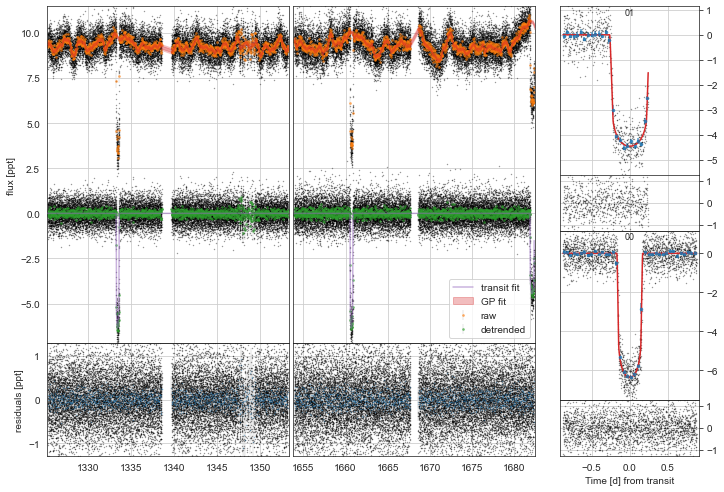

In [12]:
model.Plot(n_samp=1,overwrite=True)

### Running the MCMC
Now we can run the Mcmc using `model.RunMcmc`. We don't want this to take too long, so let's only get 200 draws per chain:

In [13]:
model.RunMcmc(n_draws=200)

['/Volumes/LUVOIR/MonoToolsData/TIC00270341214/TIC00270341214_2021-04-15_1', '/Volumes/LUVOIR/MonoToolsData/TIC00270341214/TIC00270341214'] False


Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [power, w0, logs2, mean, u_star_tess, tdur_01, b_01, logror_01, mono_uniform_index_01, t0_01, tdur_00, b_00, logror_00, t0_2_00, t0_00, Rs, logrho_S]
Sampling 4 chains, 0 divergences: 100%|██████████| 1328/1328 [33:57<00:00,  1.53s/draws] 
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


['gp_', '_gp', 'light_curve', '__', 'mono_uniform_index', 'logliks', '_priors', 'logprob_marg', 'mean', 'logrho_S', 'mono_pers', 'duo_pers', 'mono_eccs', 'duo_eccs', 'mono_omegas', 'duo_omegas'] ['Rs', 'logs2', 'rho_S', 'Ms', 't0_00', 't0_2_00', 'per_00', 'logror_00', 'ror_00', 'rpl_00', 'b_00', 'tdur_00', 'vel_00', 'logvel_00', 'min_ecc_00', 'omega_00', 'a_Rs_00', 't0_01', 'per_01', 'logror_01', 'ror_01', 'rpl_01', 'b_01', 'tdur_01', 'vel_01', 'logvel_01', 'min_ecc_01', 'omega_01', 'a_Rs_01', 'u_star_tess', 'w0', 'power', 'S0', 'per_prior_00', 'max_ecc_00', 'v_prior_00', 'logprior_00', 'per_prior_01', 'max_ecc_01', 'v_prior_01', 'gap_width_prior_01', 'logprior_01', 'logprob_00', 'ecc_00', 'ecc_marg_00', 'vel_marg_00', 'per_marg_00', 'logprob_01', 'ecc_01', 'ecc_marg_01', 'vel_marg_01', 'per_marg_01', 'marg_all_lc_model']
Saving sampled model parameters to file with shape:  (9307, 16)


#### Plotting
So now let's plot the results!

[0.49502626 0.50497374] [ 0 12 24] 32 range(0, 2)
initialising transit
Initalising Transit models for plotting with n_samp= 17
Initalising GP models for plotting with n_samp= 17


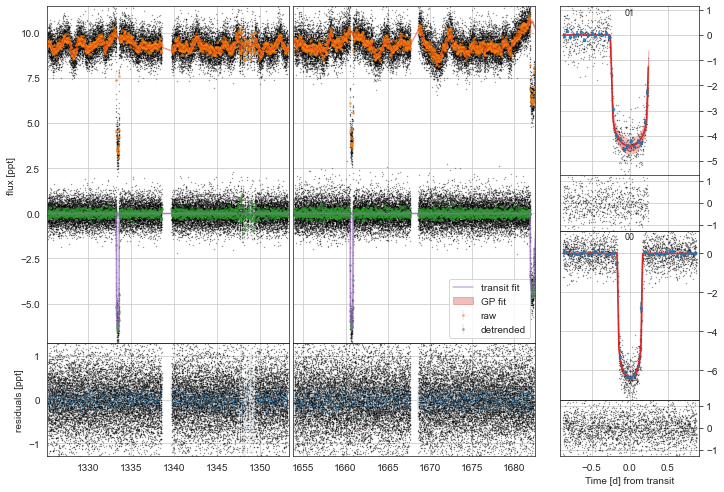

In [16]:
model.Plot(n_samp=17,overwrite=True) 
#This can be slow as we need to recreate the GP using the values in the trace (as we do not store the full GP prediction)

29.66835166975948 -3 -2.399163171138524
31.062751669759503 -3 -2.4708136846734505
32.36419166975952 -3 -2.499310990033307
34.22339166975955 -3 -2.601888680096659
35.617791669759576 -3 -2.6129317930405214
38.034751669759615 -3 -2.7405444939549857
39.615071669759644 -3 -2.7409431694603
42.77571166975969 -3 -2.8894255478373463
44.54195166975972 -3 -2.8817081916813074
48.91107166975979 -4 -3.0537996546814337
50.95619166975982 -4 -3.0498139585033215
57.09155166975992 -4 -3.2434515851425116
59.41555166975996 -4 -3.2369196453218456
68.5256316697601 -4 -3.4379181043046994
71.31443166976014 -4 -3.435711274510074
85.63027166976038 -4 -3.6133389907946607
89.16275166976042 -4 -3.5464617694010196
114.16899166976083 -4 -3.4997712249983617
118.9099516697609 -4 -3.964640870571897
171.24643166976173 -5 -4.838530916330299
178.49731166976187 -6 -5.615957908739526
342.57171166976445 -6 -7.609619609701953
356.9805116697647 -6 -8.577358528121257


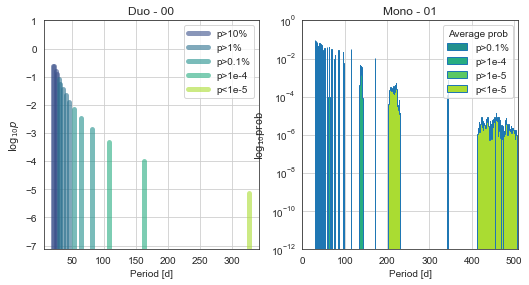

In [36]:
model.PlotPeriods()

variables for Corner: ['logrho_S', 'logror_00', 'b_00', 'tdur_00', 't0_00', 't0_2_00', 'per_marg_00', 'ecc_marg_00', 'logror_01', 'b_01', 'tdur_01', 't0_01', 'per_marg_01', 'ecc_marg_01']


Here's all of the potential parameters from the MCMC trace:
 ['logrho_S_interval__', 'Rs', 't0_00_interval__', 't0_2_00_interval__', 'logror_00_interval__', 'b_00_impact__', 'tdur_00_interval__', 't0_01_interval__', 'mono_uniform_index_01_logodds__', 'logror_01_interval__', 'b_01_impact__', 'tdur_01_interval__', 'u_star_tess_interval__', 'mean', 'logs2', 'w0_interval__', 'power_interval__', 'logrho_S', 'rho_S', 'Ms', 't0_00', 't0_2_00', 'per_00', 'logror_00', 'ror_00', 'rpl_00', 'b_00', 'tdur_00', 'vel_00', 'logvel_00', 'min_ecc_00', 'omega_00', 'a_Rs_00', 't0_01', 'mono_uniform_index_01', 'per_01', 'logror_01', 'ror_01', 'rpl_01', 'b_01', 'tdur_01', 'vel_01', 'logvel_01', 'min_ecc_01', 'omega_01', 'a_Rs_01', 'u_star_tess', 'w0', 'power', 'S0', '00_light_curves', 'per_prior_00', 'max_ecc_00', 'v_prior_00', 'logprior_00', '01_light_curves', 'per_prior_01', 'max_ecc_01', 'v_prior_01', 'gap_width_prior_01', 'logprior_01', 'logprob_00', 'logprob_marg_00', 'ecc_00', 'ecc_marg_00', 'vel_marg

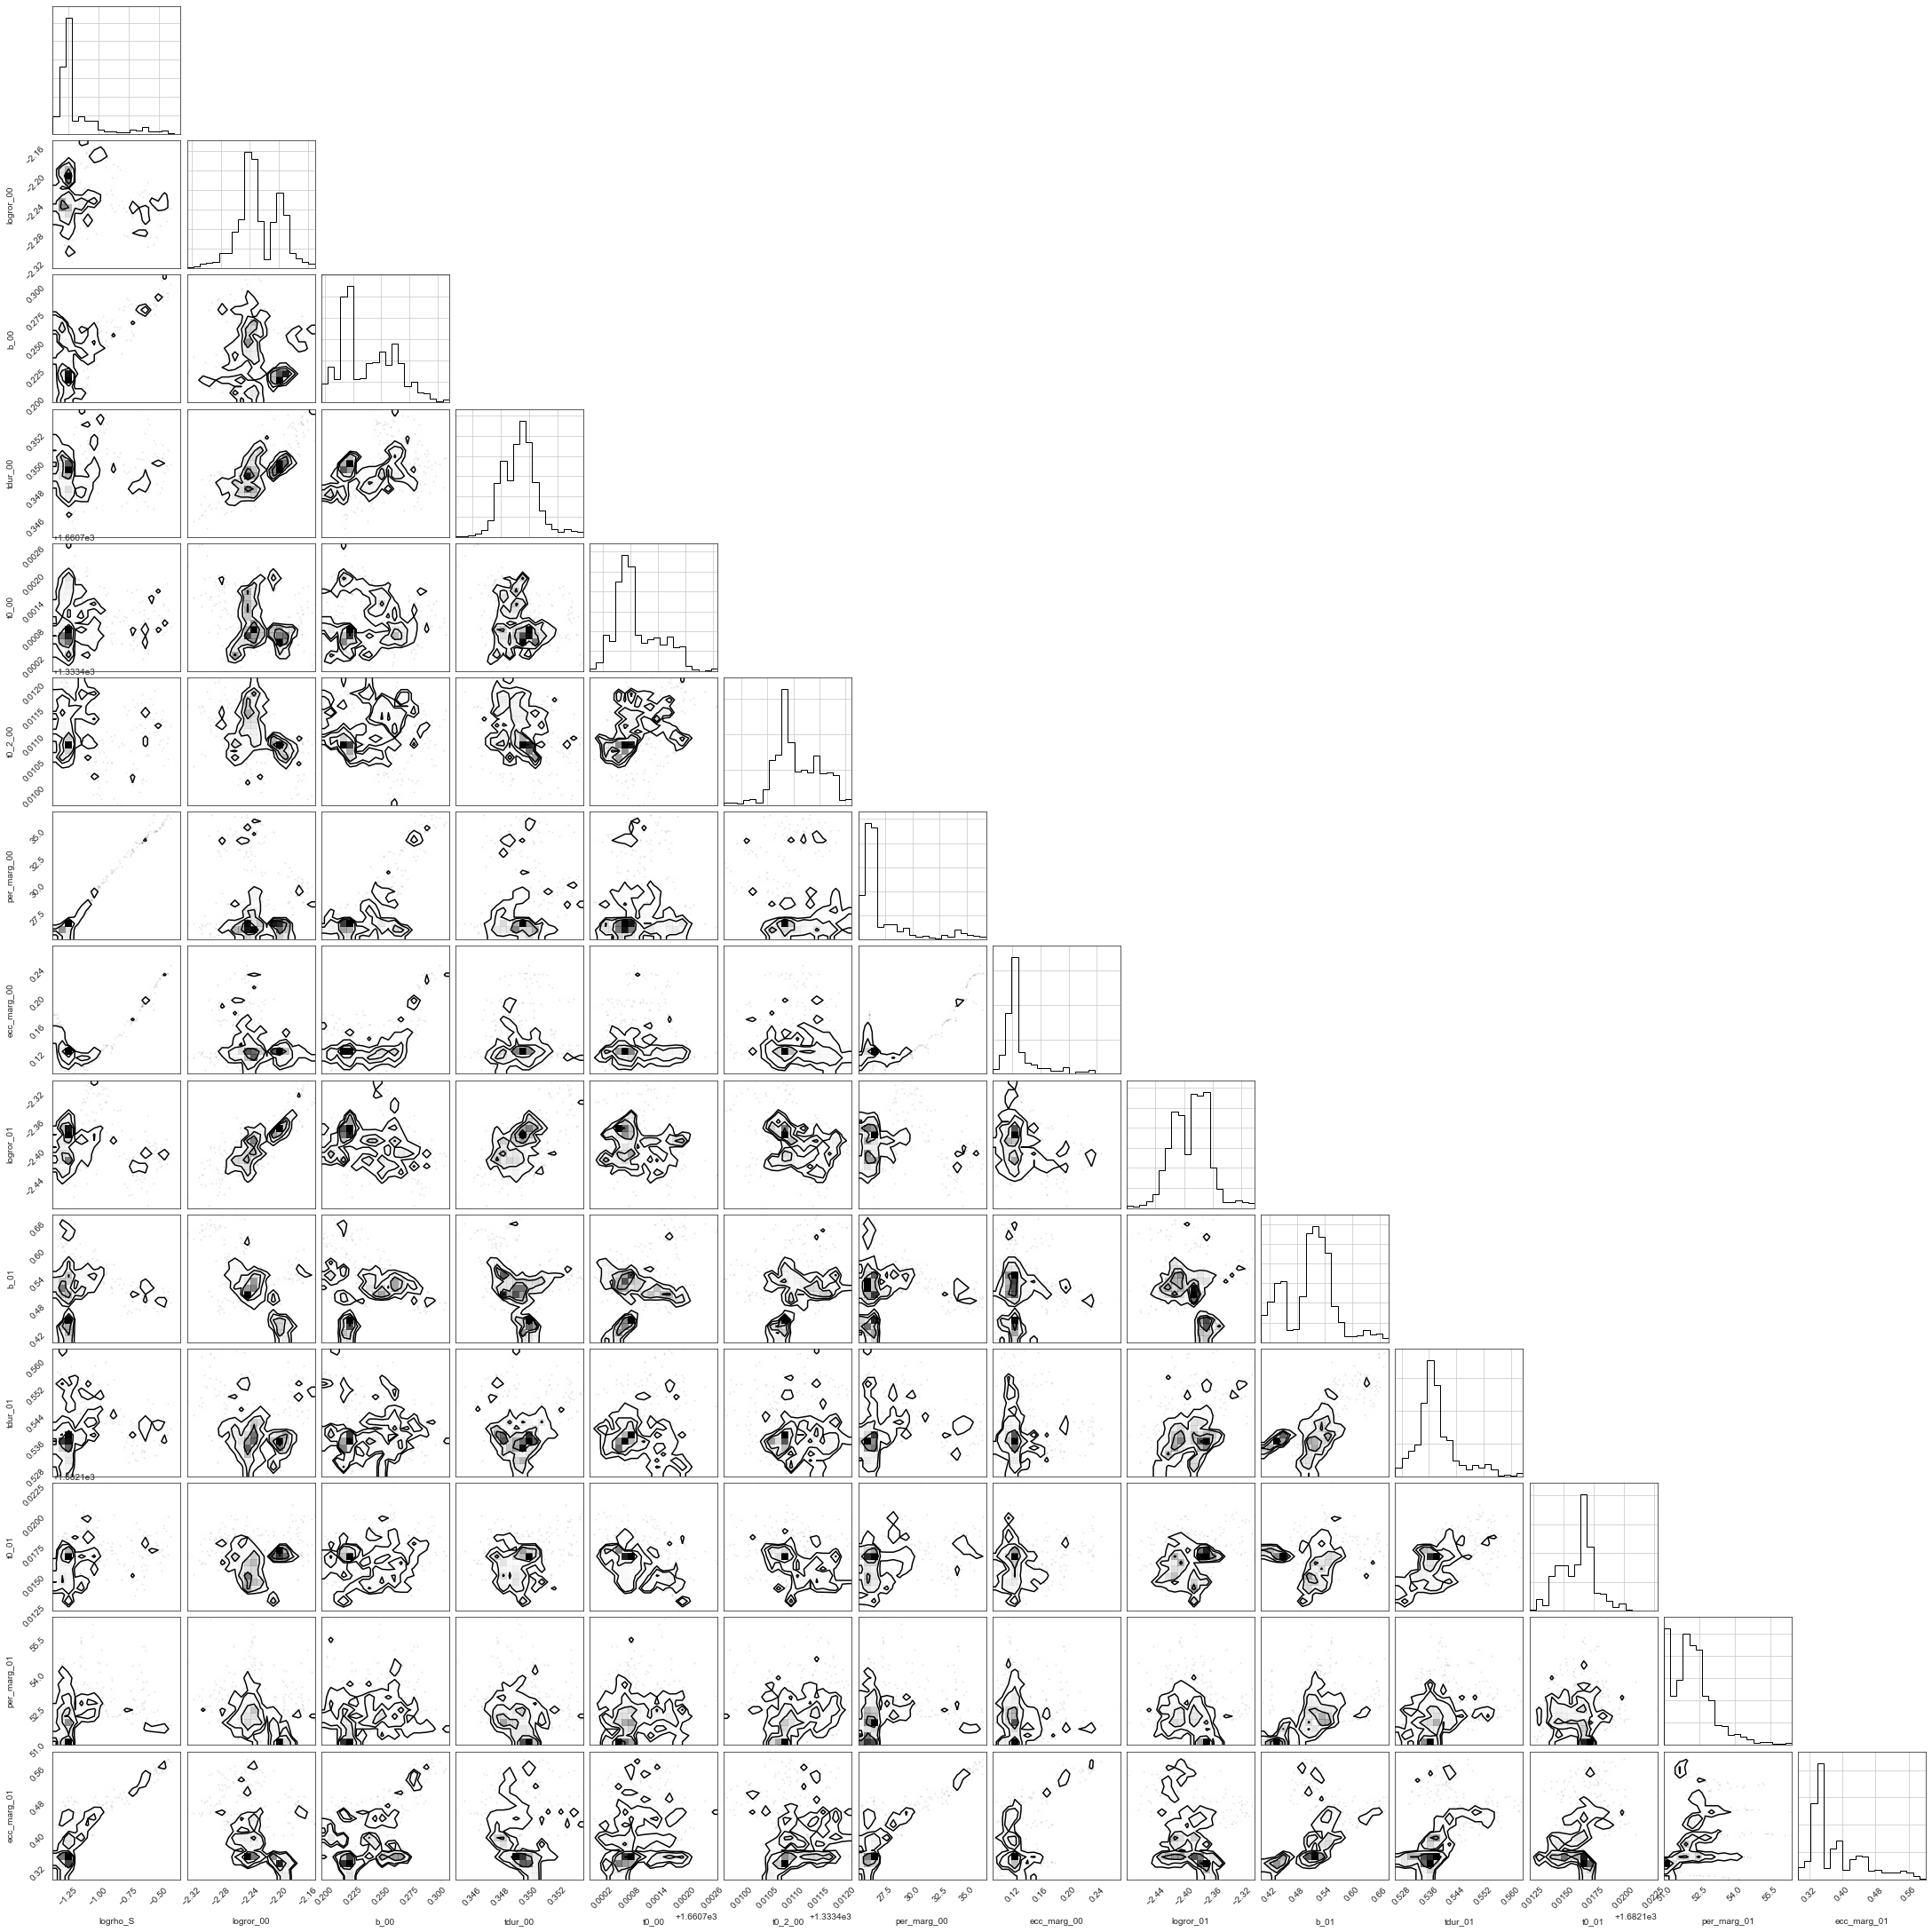

In [18]:
model.PlotCorner()

#We can set what we want to plot here using corner_vars.
print("Here's all of the potential parameters from the MCMC trace:\n",model.trace.varnames)

This was only a very quick MCMC trace so we don't have the best trace yet.

In order to access the probabilities for the duotransit candidate, we can use the log probabilities within the trace:

In [34]:
{str(model.planets['00']['period_aliases'][n_alias])[:6]:np.exp(np.nanmedian(model.trace['logprob_marg_00'][:,n_alias])) for n_alias in np.arange(model.planets['00']['npers'])[::-1]}

{'21.820': 0.231102468209237,
 '23.379': 0.2184265975053522,
 '25.177': 0.15409286668325736,
 '27.276': 0.1121224467876174,
 '29.755': 0.07916767026887109,
 '32.731': 0.05228711169153182,
 '36.368': 0.03348857568127681,
 '40.914': 0.020578105138116438,
 '46.758': 0.011961198275088762,
 '54.552': 0.006457836525541828,
 '65.462': 0.003145276815833349,
 '81.828': 0.001318881607154,
 '109.10': 0.00043635421169969864,
 '163.65': 9.392955287530953e-05,
 '327.31': 7.141242361239414e-06}

In [26]:
np.exp(np.nanmedian(model.trace['logprob_marg_00'][:,6]))

0.011961198275088762

Data from Yr3 confirmed P=29.75367 for planet b, which corresponds to 8% probability here.

### Including RVs

To see how RVs would be included, see the `Fit_with_RVs_example.ipynb`example notebook